# Point cloud based surface defect detection 
### Author: Chen Lequn
#### Initial commit: 26 Jan, 2021



## **Notebook 1 (b): point cloud clustering**

## Introduction
This notebook is for pre-processing the point cloud data

## Set up

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

import pandas as pd
import open3d as o3d
import numpy as np
import math
import open3d

from shapely.geometry import Polygon
from shapely.geometry import MultiLineString
from shapely.geometry import LineString
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, Polygon,LinearRing, MultiPoint

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
# %matplotlib auto
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = ".."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "png_images")
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "dataset")
XYZ_point_PATH = os.path.join(DATA_PATH, "xyz")
PCD_file_PATH = os.path.join(DATA_PATH, "pcd")
file_output_dir =  os.path.join(PROJECT_ROOT_DIR, "output_dir/surface_fitting_result")
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(file_output_dir, exist_ok=True)


## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import sys  
import os
import numpy as np
sys.path.insert(0, '../utils')

import utils_functions
from utils_functions import plot_line, plot_coords, color_isvalid, color_issimple, plot_line_isvalid, plot_line_issimple
from utils_functions import plot_bounds, add_origin, set_limits
from utils_functions import LinePolygonIntersectionPoints, sort_MultiPoint, LineInPolygonSegmentation, grid_line_creation, visualize_grid_line_generation
from utils_functions import reverse_MultiLineString, visualize_grid_polygon_segmentation, zig_zag_segmentation, visualize_grid_polygon_segmentation
from utils_functions import visualize_bulge_area, calculate_polygon_bondary_with_point_clusters, visualize_DBSCAN
from utils_functions import visualize_fuzzy_c_mean
from ConcaveHull import ConcaveHull

In [3]:
BLUE = '#6699cc'
GRAY = '#999999'
DARKGRAY = '#333333'
YELLOW = '#ffcc33'
GREEN = '#339933'
RED = '#ff3333'
BLACK = '#000000'

COLOR_ISVALID = {
    True: BLUE,
    False: RED,
}

In [4]:
import matplotlib.colors as mcolors

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen', 
          '#90EE90', '#0f0f0f80', '#2F1F5E', '#F11FA9', '#F1FAA9', '#F1D9A9']

# Sort colors by hue, saturation, value and name.


colors.extend(list(mcolors.TABLEAU_COLORS))
colors.extend(list(mcolors.CSS4_COLORS))

len(colors)

174

### File IO by open3d

In [5]:
print("Testing IO for point cloud ...")

##--------------read point cloud data, save to a open3d object--------------
pcd = o3d.io.read_point_cloud(os.path.join(PCD_file_PATH, "30_seg_rot.pcd"))
# pcd = o3d.io.read_point_cloud(os.path.join(PCD_file_PATH, "point_cloud_example.pcd"))
print(pcd)

print("Downsample the point cloud with a voxel of 0.3")
downsample_pcd = pcd.voxel_down_sample(voxel_size=0.3)

Testing IO for point cloud ...
PointCloud with 21798 points.
Downsample the point cloud with a voxel of 0.3


## 2. Point cloud visualizaiton by matplotlib

### - calculate the mean Z value (mean height of the top surface)

In [6]:
# ---- using numpy to print all the points -------
points_np_array = np.asarray(pcd.points)
print("the points converted to numpy are: \n")
print(points_np_array)
#------extract x,y,z value of the points-----
# ------------standarization-----------
# bbdiag = float(np.linalg.norm(points_np_array.max(0) - points_np_array.min(0), 2))
# points_np_array = (points_np_array - points_np_array.mean(0))/bbdiag
# print("the points are: \n")
# print(points_np_array)

scale = 1
x = points_np_array[:,0]* scale ## from m to mm
y = points_np_array[:,1]*scale  ## from m to mm
points_np_array[:,2] = points_np_array[:,2] - np.amin(points_np_array[:,2]) 
z = points_np_array[:,2]*scale  ## from m to mm
print("the z value extracted:" )
print (z)

# --------mean height-------------------
z_mean = np.mean(z)
print("Z mean: " + str(z_mean))

z_min = np.amin(z)
z_max = np.amax(z)
print ("Z minimum: "+ str(z_min))
print ("Z max: "+ str(z_max))


the points converted to numpy are: 

[[-13.84774583 -14.73133736   0.47270684]
 [-13.99546204 -14.56224483   0.48745801]
 [-14.10493174 -14.4094093    0.4682581 ]
 ...
 [ 12.0776545   13.18580701   1.68861493]
 [ 12.26074167  13.1871676    1.68418764]
 [ 11.68067066  13.40103275   1.7008424 ]]
the z value extracted:
[0.47270684 0.48745801 0.4682581  ... 1.68861493 1.68418764 1.7008424 ]
Z mean: 1.117028044460246
Z minimum: 0.0
Z max: 1.816255610021727


## plane for segmentation

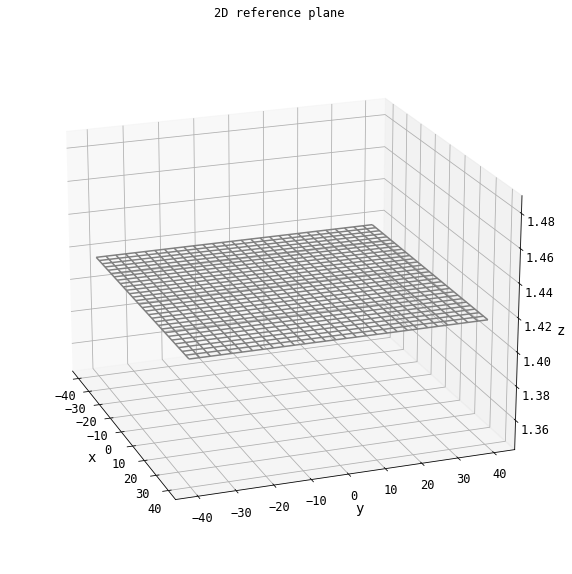

In [7]:
# tune the segmentation line
z_segment = z_max - 0.4 

# Plot for a three-dimensional Plane
# this function is currently not used
def z_function(x, y):
    # ax+by+cz = d ---> z = -(ax+by-d)/c
    return  z_segment + 0 * x + 0 * y       

# create a plane with meshgrid (mainly for visualization purpose)
# x_plane = np.linspace(-11, 11, 30)
# y_plane = np.linspace(-21, 21, 30)
x_plane = np.linspace(-40, 40, 30)
y_plane = np.linspace(-40, 40, 30)

X, Y = np.meshgrid(x_plane, y_plane)
Z = z_function(X, Y) # the Z value (height) of the nominal plane is equal to the mean Z value of the point l
#print (X, Y, Z)


plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_wireframe(X, Y, Z, color='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.title('2D reference plane')

ax.view_init(elev=20,azim=-20) #rotate the graph
# save_fig("01_reference_plane")

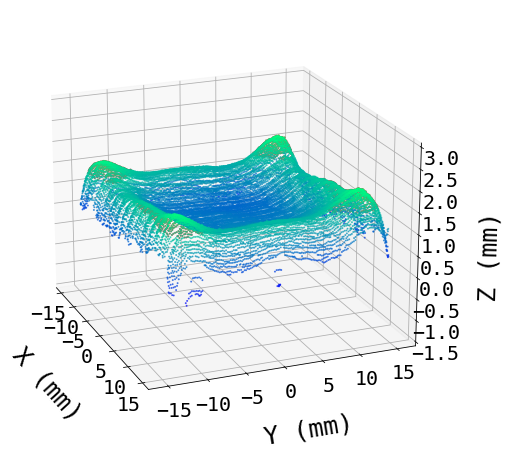

In [8]:
# this will make the plot interactive
# %matplotlib auto
x = points_np_array[:,0]
y = points_np_array[:,1]
points_np_array[:,2] = points_np_array[:,2] - np.amin(points_np_array[:,2]) 
z = points_np_array[:,2]


plt.figure(figsize=(16, 8))
# plt.figure()
ax = plt.axes(projection='3d')

### plot the wireframe
# ax.plot_wireframe(X, Y, Z, color='gray',  alpha=0.6)
# Data for three-dimensional scattered points, extracted from numpy array
# p = ax.scatter3D(x, y, z, c=z, cmap='winter', s = 5, alpha=0.6) # other cmap options: winter, Greens
ax.scatter3D(x, y, z, c=z, cmap='winter', s = 1, alpha=0.6)

points_new = points_np_array[((points_np_array[:,2] > (z_segment))),:]
x = points_new[:,0]
y = points_new[:,1]
z = points_new[:,2]
ax.scatter3D(x, y, z, c = 'r', s = 1, alpha=0.6)
# cbar = plt.colorbar(p)
# cbar.ax.set_ticks(np.arange(0, 2, 0.5))
# cbar.set_label("Z Height (mm)", fontsize=16, labelpad=15)
ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
# ax.set_zticks([0, 0.5, 1, 1.5, 2])
ax.set_zlim(-1.5, 3)
# ax.set_xticks([-20, -10, 0, 10, 20])
# ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)

# to hide the 3D axes
ax._axis3don = True

# plt.title('3D Point cloud and reference plane')
ax.view_init(elev=20,azim=-22) #rotate the graph
# save_fig("02_visualization of 3D point cloud with the reference plane")

## DBSCAN clustering algorihtm on 3D point cloud

In [9]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from matplotlib import transforms

# #############################################################################
point_cloud_transformed = StandardScaler().fit_transform(points_np_array)
# Compute DBSCAN
db = DBSCAN(eps=0.35, min_samples=10).fit(point_cloud_transformed)
# db = DBSCAN(eps=1, min_samples=10).fit(extracted_2D_downsampled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_ # "labels" is a list of index for EACH point: -1: noise, 0: cluster 1, 1: cluster 2,.......

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 25


### Plot point cloud clusters

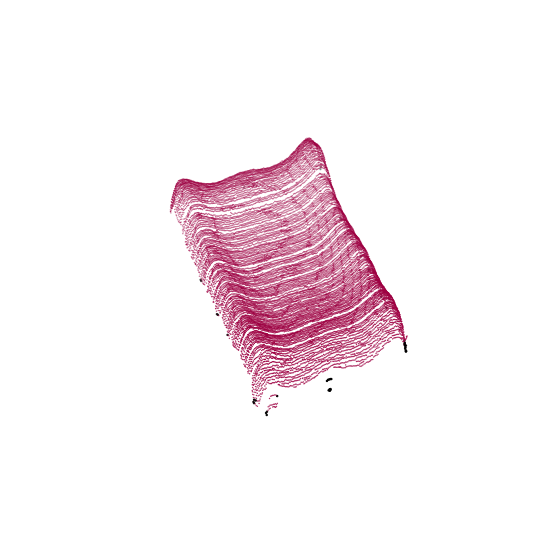

In [10]:
plt.figure(figsize=(20, 10))
# plt.figure()
ax = plt.axes(projection='3d')


#------------------------------------------------------------------------------
## set colors for differnt labels
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

point_clusters = []
cluster = 0 
while cluster < n_clusters_:
    class_member_mask = (labels == cluster)
    point_clusters.append(points_np_array[class_member_mask & core_samples_mask])
#     point_clusters.append(extracted_2D_downsampled[class_member_mask & core_samples_mask])
    cluster = cluster + 1
    
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xyz = points_np_array[class_member_mask & core_samples_mask]
#     xy = extracted_2D_downsampled[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14)
    ax.scatter3D(xyz[:, 0], xyz[:, 1],xyz[:, 2], '.', facecolor=tuple(col),
             edgecolor='None', s=2)

    # these are the points does not belong to either clusters (noise)
    xyz = points_np_array[class_member_mask & ~core_samples_mask]
#     xy = extracted_2D_downsampled[class_member_mask & ~core_samples_mask]
    ax.scatter3D(xyz[:, 0], xyz[:, 1], xyz[:, 2], '.', facecolor=tuple(col),
             edgecolor='k', s=2)
#-----------------------------------------------------------------------------------------------


ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
# ax.set_zticks([0, 0.5, 1, 1.5, 2])
# ax.set_zticks([-1, -0.5, 2, 3, 4])
ax.set_zlim(-1.5, 3)
ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

ax._axis3don = False

for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)
# plt.title('3D Point cloud and reference plane')
ax.view_init(elev=60,azim=-20) #rotate the graph
# save_fig("02_visualization of 3D point cloud with the reference plane")

### Gaussian mixture model

In [11]:
from sklearn.mixture import GaussianMixture
# Suppose Data X is a 2-D Numpy array (One apple has two features, size and flavor)
GMM = GaussianMixture(n_components=3, random_state=0).fit(points_np_array)

## Fuzzy c-means clustering algorithm

Fuzzy logic principles can be used to cluster multidimensional data, assigning each point a membership in each cluster center from 0 to 100 percent. This can be very powerful compared to traditional hard-thresholded clustering where every point is assigned a crisp, exact label.

Fuzzy c-means clustering is accomplished via __skfuzzy.cmeans__, and the output from this function can be repurposed to __classify__ new data according to the calculated clusters (also known as prediction) via __skfuzzy.cmeans_predict__

Reference
- https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html
- https://www.sciencedirect.com/science/article/pii/0098300484900207?via%3Dihub

In [12]:
import skfuzzy as fuzz
from fcmeans import FCM

In [13]:
points_np_array.shape

(21798, 3)

In [14]:
points_np_array_transpose = np.transpose(points_np_array)
print (points_np_array_transpose)

[[-13.84774583 -13.99546204 -14.10493174 ...  12.0776545   12.26074167
   11.68067066]
 [-14.73133736 -14.56224483 -14.4094093  ...  13.18580701  13.1871676
   13.40103275]
 [  0.47270684   0.48745801   0.4682581  ...   1.68861493   1.68418764
    1.7008424 ]]


In [15]:
# skfuzzy.cmeans(data, ncenters, m, error, maxiter, init=None, seed=None)
# Input:
# m : float -- Array exponentiation applied to the membership function u_old at each iteration, where U_new = u_old ** m.
# error : float -- Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
# maxiter : int Maximum number of iterations allowed.
## init : 2d array, size (S, N) -- Initial fuzzy c-partitioned matrix. If none provided, algorithm is randomly initialized.

# Output:
# cntr : 2d array, size (S, c) -- Cluster centers. Data for each center along each feature provided for every cluster (of the c requested clusters)
# u : 2d array, (S, N) -- Final fuzzy c-partitioned matrix.
# u0 : 2d array, (S, N) -- Initial guess at fuzzy c-partitioned matrix (either provided init or random guess used if init was not provided).
# d : 2d array, (S, N) -- Final Euclidian distance matrix.
# jm : 1d array, length P -- Objective function history.
# p : int -- Number of iterations run.
# fpc : float -- Final fuzzy partition coefficient

ncenters = 10
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(points_np_array_transpose, ncenters, m=10, error=0.001, maxiter=1000, init=None)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

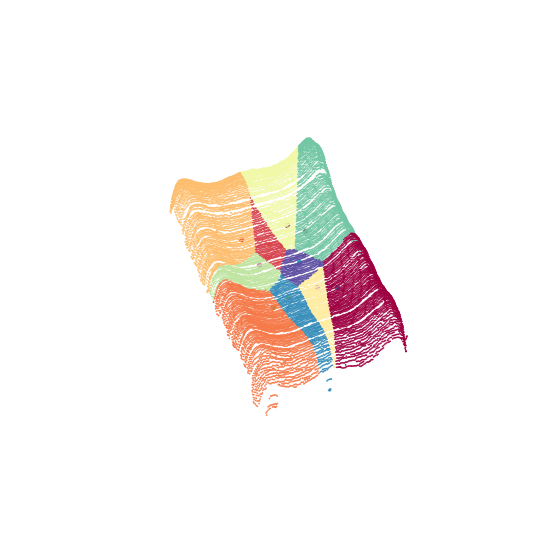

In [16]:
visualize_fuzzy_c_mean(points_np_array, u, ncenters, cntr, show_axis = False)

### OPTICS clustering

In [17]:
# from sklearn.cluster import OPTICS, cluster_optics_dbscan
# import matplotlib.gridspec as gridspec
# import matplotlib.pyplot as plt
# import numpy as np

# clust = OPTICS(min_samples=20, xi=0.05, min_cluster_size=10)

# # Run the fit
# clust.fit(points_np_array)

# space = np.arange(len(points_np_array))
# reachability = clust.reachability_[clust.ordering_]
# labels = clust.labels_[clust.ordering_]

In [18]:
# plt.figure(figsize=(10, 7))
# # G = gridspec.GridSpec(2, 3)
# # ax1 = plt.subplot(G[0, :])
# # ax2 = plt.subplot(G[1, 0])
# ax2 = plt.axes(projection='3d')

# # Reachability plot
# # colors = ["g.", "r.", "b.", "y.", "c."]
# # for klass, color in zip(range(0, 5), colors):
# #     Xk = space[labels == klass]
# #     Rk = reachability[labels == klass]
# #     ax1.plot(Xk, Rk, color, alpha=0.3)
# # ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
# # ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
# # ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
# # ax1.set_ylabel("Reachability (epsilon distance)")
# # ax1.set_title("Reachability Plot")

# # OPTICS
# colors = ["g.", "r.", "b.", "y.", "c."]
# for klass, color in zip(range(0, 5), colors):
#     Xk = points_np_array[clust.labels_ == klass]
#     ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
# ax2.plot(points_np_array[clust.labels_ == -1, 0], points_np_array[clust.labels_ == -1, 1], "k+", alpha=0.1)
# ax2.set_title("Automatic Clustering\nOPTICS")



# plt.tight_layout()
# plt.show()

## Test on segmented point clouds

In [19]:
pointsDF = pd.DataFrame(data=points_np_array, columns=["X", "Y", "Z"])
bulgePointsDF = pointsDF[pointsDF['Z'] > z_max - 0.5]
dentPointsDF = pointsDF[pointsDF['Z'] < z_mean ]

In [20]:
if not bulgePointsDF.empty:
    ## Create "bulge" point cloud:
    bulgePointsNP = bulgePointsDF.to_numpy()  # convert Pandas dataframe to numpy array
    bulgePointsPCD = open3d.geometry.PointCloud()  # define a point cloud
    bulgePointsPCD.points = open3d.utility.Vector3dVector(bulgePointsNP)  # pass numpy array to point cloud
    # open3d.visualization.draw_geometries([bulgePointsPCD])
    
    # #############################################################################
    bulgePointsDF_transformed = StandardScaler().fit_transform(bulgePointsDF)
    # Compute DBSCAN
    db = DBSCAN(eps=0.35, min_samples=10).fit(bulgePointsDF_transformed)
    # db = DBSCAN(eps=1, min_samples=10).fit(extracted_2D_downsampled)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_ # "labels" is a list of index for EACH point: -1: noise, 0: cluster 1, 1: cluster 2,.......

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 0


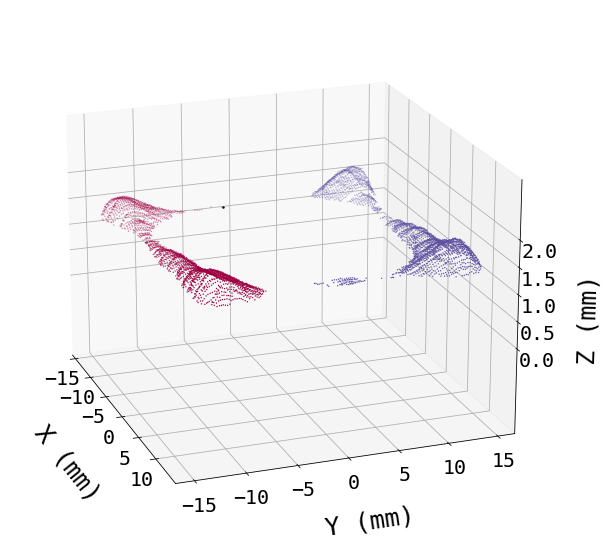

In [21]:
visualize_DBSCAN(labels, n_clusters_, bulgePointsNP, core_samples_mask, save = False, show_axis = True)

In [22]:
if not dentPointsDF.empty:
    ## Create "dent" point cloud:
    dentPointsNP = dentPointsDF.to_numpy()  # convert Pandas dataframe to numpy array
    dentPointsPCD = open3d.geometry.PointCloud()  # define a point cloud
    dentPointsPCD.points = open3d.utility.Vector3dVector(dentPointsNP)  # pass numpy array to point cloud
    # open3d.visualization.draw_geometries([dentPointsPCD])
    
    # #############################################################################
    dentPointsDF_transformed = StandardScaler().fit_transform(dentPointsDF)
    # Compute DBSCAN
    db = DBSCAN(eps=0.35, min_samples=10).fit(dentPointsDF_transformed)
    # db = DBSCAN(eps=1, min_samples=10).fit(extracted_2D_downsampled)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_ # "labels" is a list of index for EACH point: -1: noise, 0: cluster 1, 1: cluster 2,.......

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 6
Estimated number of noise points: 67


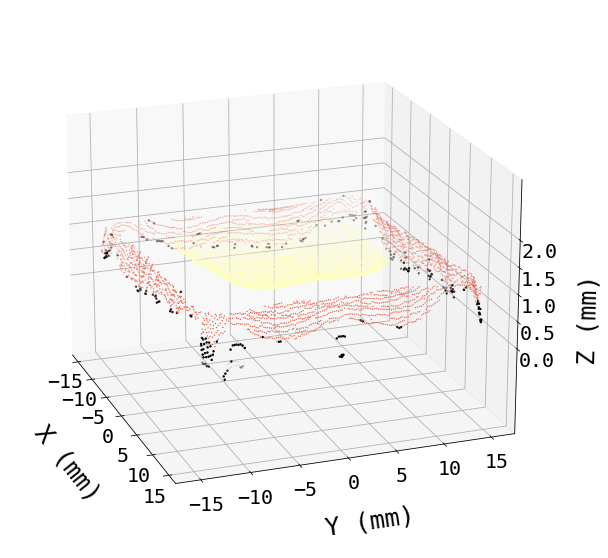

In [23]:
visualize_DBSCAN(labels, n_clusters_, dentPointsNP, core_samples_mask, save = False, show_axis = True)

## Fuzzy C-mean

In [24]:
ncenters = 5
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(np.transpose(bulgePointsNP), ncenters, m=10, error=0.001, maxiter=1000, init=None)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

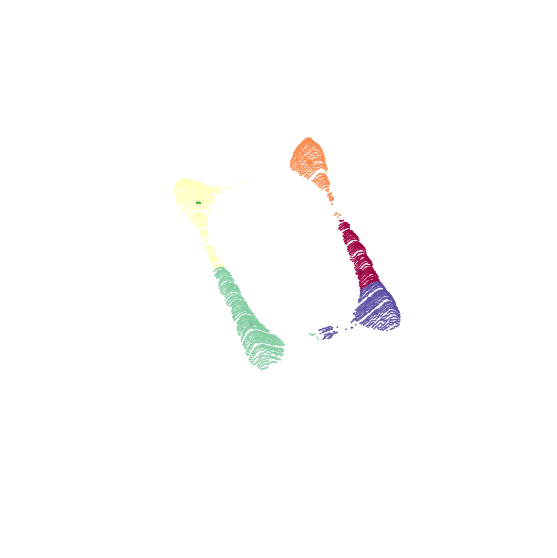

In [25]:
visualize_fuzzy_c_mean(bulgePointsNP, u, ncenters, cntr, show_axis = False)